In [1]:
import sys
import torch
import pickle
import numpy as np
sys.path.insert(0, "../../src")
from models import CNNModel
import matplotlib.pyplot as plt
from datasets import MVTSDataset
import matplotlib.colors as mcolors
from captum.attr import GuidedGradCam
import matplotlib.gridspec as gridspec
from torch.utils.data import DataLoader
from matplotlib.ticker import MultipleLocator
plt.rcParams['font.size'] = 8

In [2]:
def plot_attributions(mvts, attribution_mask, name=None):

    dtypes = ['94', '131', '171', '193', '211', '304', '335', '1600', '1700', 'M_45s', 'V_45s',
            'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ',
            'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH',
            'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'XR_MAX']

    mvts = mvts.T
    attribution_mask = attribution_mask.T

    mvts[mvts==0] = np.nan
    mvts = unity_based_normalization(mvts) # normalize the data so easier to see each feature in the original data

    n_void = np.isnan(mvts[0]).sum()

    fig = plt.figure(figsize=(6, 25))
    gs = gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 1, 4], width_ratios=[1, 1, 1], hspace=0.2, wspace=0.3)
    with open('/Users/brandonlpanos/custom_cmap.pkl', 'rb') as f: custom_cmap = pickle.load(f)

    # plot input mvt
    ax1 = fig.add_subplot(gs[0:1, :])
    ax1.set_title(f'mvts')
    ax1.set_ylabel('Features')
    ax1.set_xlabel('Time (min) before flare start')
    im1 = ax1.imshow(mvts, aspect='auto', cmap='gray', interpolation='spline16', vmin=0, vmax=np.nanmax(mvts), extent=[180, 0, 35, 0], alpha=0.5)
    ax1.yaxis.grid(True, "major")
    ax1.xaxis.grid(True, "major")
    ax1.xaxis.set_major_locator(MultipleLocator(20))
    ax1.xaxis.set_minor_locator(MultipleLocator(10))
    ax1.yaxis.set_major_locator(MultipleLocator(5))
    ax1.yaxis.set_minor_locator(MultipleLocator(1))
    ax1.tick_params(which='major', length=5,width=1)
    ax1.tick_params(which='minor', length=3,width=1)
    cbar1 = plt.colorbar(im1, cax=ax1.inset_axes([1.01, 0, 0.01, 1]), aspect=10)
    cbar1.set_label('Intensity')
    cbar1.ax.set_yticks([]) 

    # Plot saliency map
    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_title('saliency map')
    ax2.set_ylabel('Features')
    ax2.set_xlabel('Time (min) before flare start')
    attribution_mask[:,0:n_void] = np.nan
    im2 = ax2.imshow(attribution_mask, aspect='auto', cmap=custom_cmap, interpolation='spline16', extent=[180, 0, 35, 0], alpha=1)
    ax2.yaxis.grid(True, "major")
    ax2.xaxis.grid(True, "major")
    ax2.xaxis.set_major_locator(MultipleLocator(20))
    ax2.xaxis.set_minor_locator(MultipleLocator(10))
    ax2.yaxis.set_major_locator(MultipleLocator(5))
    ax2.yaxis.set_minor_locator(MultipleLocator(1))
    ax2.tick_params(which='major', length=5,width=1)
    ax2.tick_params(which='minor', length=3,width=1)
    cbar2 = plt.colorbar(im2, cax=ax2.inset_axes([1.01, 0, 0.01, 1]), aspect=10)
    cbar2.set_label('Intensity')
    cbar2.ax.set_yticks([]) 

    # Plot the light curves
    gs2 = gridspec.GridSpecFromSubplotSpec(6, 6, subplot_spec=gs[2, 0:], wspace=0, hspace=0)
    ax3 = fig.add_subplot(gs2[:, :])
    ax3.set_title('features (light curves)')
    for i in range(6):
        for j in range(6):
            ind = (i * 6) + j
            if ind < len(dtypes):  # Check if index is within the range of dtypes
                ax = fig.add_subplot(gs2[i, j])
                # Handle NaN values in attribution_mask
                masked_mask = np.ma.masked_invalid(attribution_mask)
                # Normalize the masked_mask to range [0, 1]
                norm = mcolors.Normalize(vmin=masked_mask.min(), vmax=masked_mask.max())
                normalized_mask = norm(masked_mask)
                # Convert the normalized mask to RGB
                cmap = custom_cmap
                rgb_colors = cmap(normalized_mask)
                light_curve = mvts[ind]
                light_curve_colors = rgb_colors[ind, :, :]
                for k, clr in enumerate(light_curve_colors):
                    if k + 1 == 40: break
                    x = [k, k+1]
                    y = [light_curve[k], light_curve[k+1]]
                    plt.plot(x, y, color=clr, linewidth=1.5)
                    plt.text(0.02, 0.85, dtypes[ind], fontfamily='Arial', fontsize=5, fontweight='ultralight', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
                    plt.xticks([])
                    plt.yticks([])
                    plt.xlim(0,40)
    ax3.set_xticks([])
    ax3.set_yticks([])
    plt.tight_layout()
    # plt.savefig(f'/Users/brandonlpanos/papers/transformer/figs/grad_cam//{name}.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)

    return None

def unity_based_normalization(data):
    '''
    Normalize each row of the data matrix by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
    Takes in arrays of shape (features, time)
    '''
    # Normalize each row by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
    # Get the maximum and minimum values of each row
    max_vals = np.nanmax(data, axis=1)
    min_vals = np.nanmin(data, axis=1)
    # Compute the range of each row, and add a small constant to avoid division by zero
    ranges = max_vals - min_vals
    eps = np.finfo(data.dtype).eps  # machine epsilon for the data type
    ranges[ranges < eps] = eps
    # Normalize each row by subtracting its minimum value, dividing by its range, and scaling to a range of 0-1
    data = (data - min_vals[:, np.newaxis]) / ranges[:, np.newaxis]
    data = data + np.nanmax(data)
    data *= (1 / np.nanmax(data, axis=1)[:, np.newaxis])
    return data

In [3]:
# Load all data
indices = np.arange(0, 485, 1)
dataloader = DataLoader(MVTSDataset(indices, norm_type='standard'), batch_size=len(indices), shuffle=False, drop_last=False)
data, _, labels = next(iter(dataloader))

/Users/brandonlpanos/gits/mvts_transformer/envmvts/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/var/folders/f9/n3qmt52j5rzc2pm_q_cmx6_80000gn/T/ipykernel_81144/873523430.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


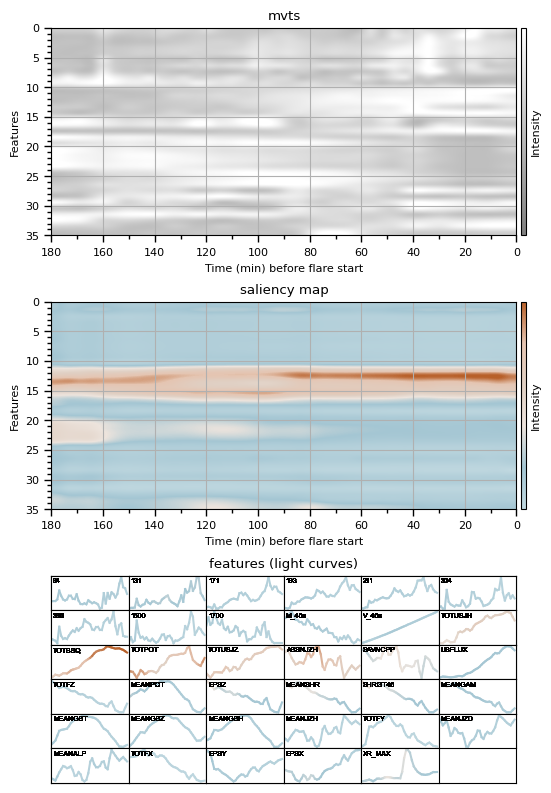

In [4]:
# Select an example

name = 'plot_grad_cam'
example_indx = 2
mvts, y = data[example_indx], labels[example_indx]
mvts = mvts.unsqueeze_(0)
mvts = mvts.unsqueeze_(1)
mvts = mvts.requires_grad_()
mvts = torch.nan_to_num(mvts)

# Itterate over all models from each 50 folds 
attribution_masks = []
for model_indx in range(50):
    if model_indx in [27,37]: continue
    # Load best model for a specific fold
    model = CNNModel()
    model.load_state_dict(torch.load(f'../../models/cnn_std/{model_indx}.pth', map_location=torch.device('cpu')))
    model.eval();
    # Create a GuidedGradCam object based on the model and the desired layer
    guided_grad_cam = GuidedGradCam(model, model.conv3)
    # Compute the attribution mask for the desired class
    attribution_mask = guided_grad_cam.attribute(mvts, target=y)
    attribution_mask = attribution_mask.squeeze().detach().numpy()
    # attribution_mask = attribution_mask / np.nanmax(attribution_mask)
    attribution_mask = unity_based_normalization(attribution_mask)
    attribution_masks.append(attribution_mask)
    # delete model
    del model

# Plot the attribution mask

mvts = mvts.squeeze().detach().numpy()
attribution_masks = np.array(attribution_masks)
attribution_mask = np.nanmean(attribution_masks, axis=0)
plot_attributions(mvts, attribution_mask, name=name)

In [5]:
# plot correspondings to fits data found at ~/sml/bpanos/old/mvts/downloads_lowcad/5983/M_897

(40, 35)